## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [ ]:
# spm.SPMCommand().version

In [4]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [5]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [6]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'nipype'
working_dir = 'workingdir'

# list of subject identifiers
subject_id = ['01']

task_id = ['auditory']

# task_id = ['auditory']
# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [7]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_id),
                        ('task_name', task_id)]
# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join( base_dir, 'MoAEpilot/', 'sub-{subject_id}', 'anat',  'sub-{subject_id}_T1w.nii' )
func_file = os.path.join( base_dir, 'MoAEpilot/', 'sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=base_dir),
                   name="selectfiles")

# Datasink - creates output folder for the needed outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [8]:
realigner = Node(interface=Realign(), name='realign')
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [9]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
slicetiming.inputs.num_slices = 64
slicetiming.inputs.time_repetition = 7.
slicetiming.inputs.time_acquisition = 6.8906
slicetiming.inputs.slice_order = list(range(64,0,-1))
slicetiming.inputs.ref_slice = 32
slicetiming.inputs.out_prefix = 'a'

https://github.com/nipy/nipype/issues/2697 check this

In [10]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
coregister.inputs.out_prefix = 'c'

In [11]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [12]:
segment =  Node(NewSegment(), name="newsegment")
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [13]:
normalize = Node(Normalize12(), name="normalize") #old normalize now
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [14]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [6, 6, 6]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [15]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False] # successive motion, # intensity parameter
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.intersect_mask = True
art.inputs.bound_by_brainmask = True
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='png'

In [16]:
block_preprocess = Workflow(name='nipype_block_preprocess')
block_preprocess.base_dir = os.path.join(experiment_dir, working_dir)

In [17]:
block_preprocess.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                              ('task_name', 'task_name')]),
                 (selectfiles, realigner, [('func', 'in_files')]),
                 (selectfiles, datasink, [('func', 'block_preprocess.@func'),
                                          ('anat', 'block_preprocess.@anat')]),  
                 (realigner, datasink, [('realignment_parameters', 'block_preprocess.@realignement_parameters'),
                                        ('realigned_files', 'block_preprocess.@realigned_files'),
                                        ('mean_image', 'block_preprocess.@mean_image')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),  
                 (slicetiming, datasink, [('timecorrected_files', 'block_preprocess.@timecorrected_files')]),
                 (realigner, coregister, [('mean_image', 'target')]),
                 (selectfiles, coregister, [('anat', 'source')]), 
                 (coregister, datasink, [('coregistered_source', 'block_preprocess.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'block_preprocess.@bias_corrected_images'),
                                      ('transformation_mat', 'block_preprocess.@transformation_mat'),
                                      ('native_class_images', 'block_preprocess.@native_class_images'),
                                      ('forward_deformation_field', 'block_preprocess.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files')]), 
                 (normalize, datasink, [('normalized_files', 'block_preprocess.@normalized_files')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'block_preprocess.@smoothed_files')]),
                 (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 (normalize, art, [('normalized_files', 'realigned_files')]),
                 (art, datasink, [('outlier_files', 'block_preprocess.@outlier_files'),
                                  ('plot_files', 'block_preprocess.@plot_files')])
])

240610-17:35:20,926 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/colored_block.png (graph2use=colored, simple_form=True).


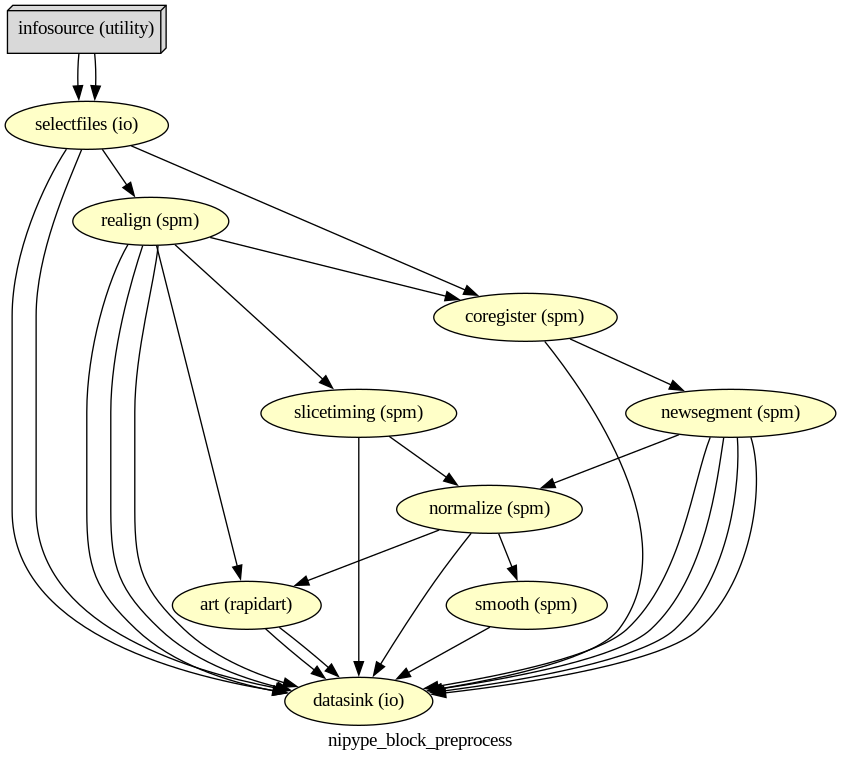

In [18]:
# Create 1st-level analysis output graph
block_preprocess.write_graph(graph2use='colored', format='png', dotfilename='colored_block.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(block_preprocess.base_dir, 'nipype_block_preprocess', 'colored_block.png'))

In [19]:
# Create 1st-level analysis output graph
block_preprocess.write_graph(graph2use='flat', format='png', dotfilename='flat_block.dot', simple_form=True)

240610-17:35:21,229 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/flat_block.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/flat_block.png'

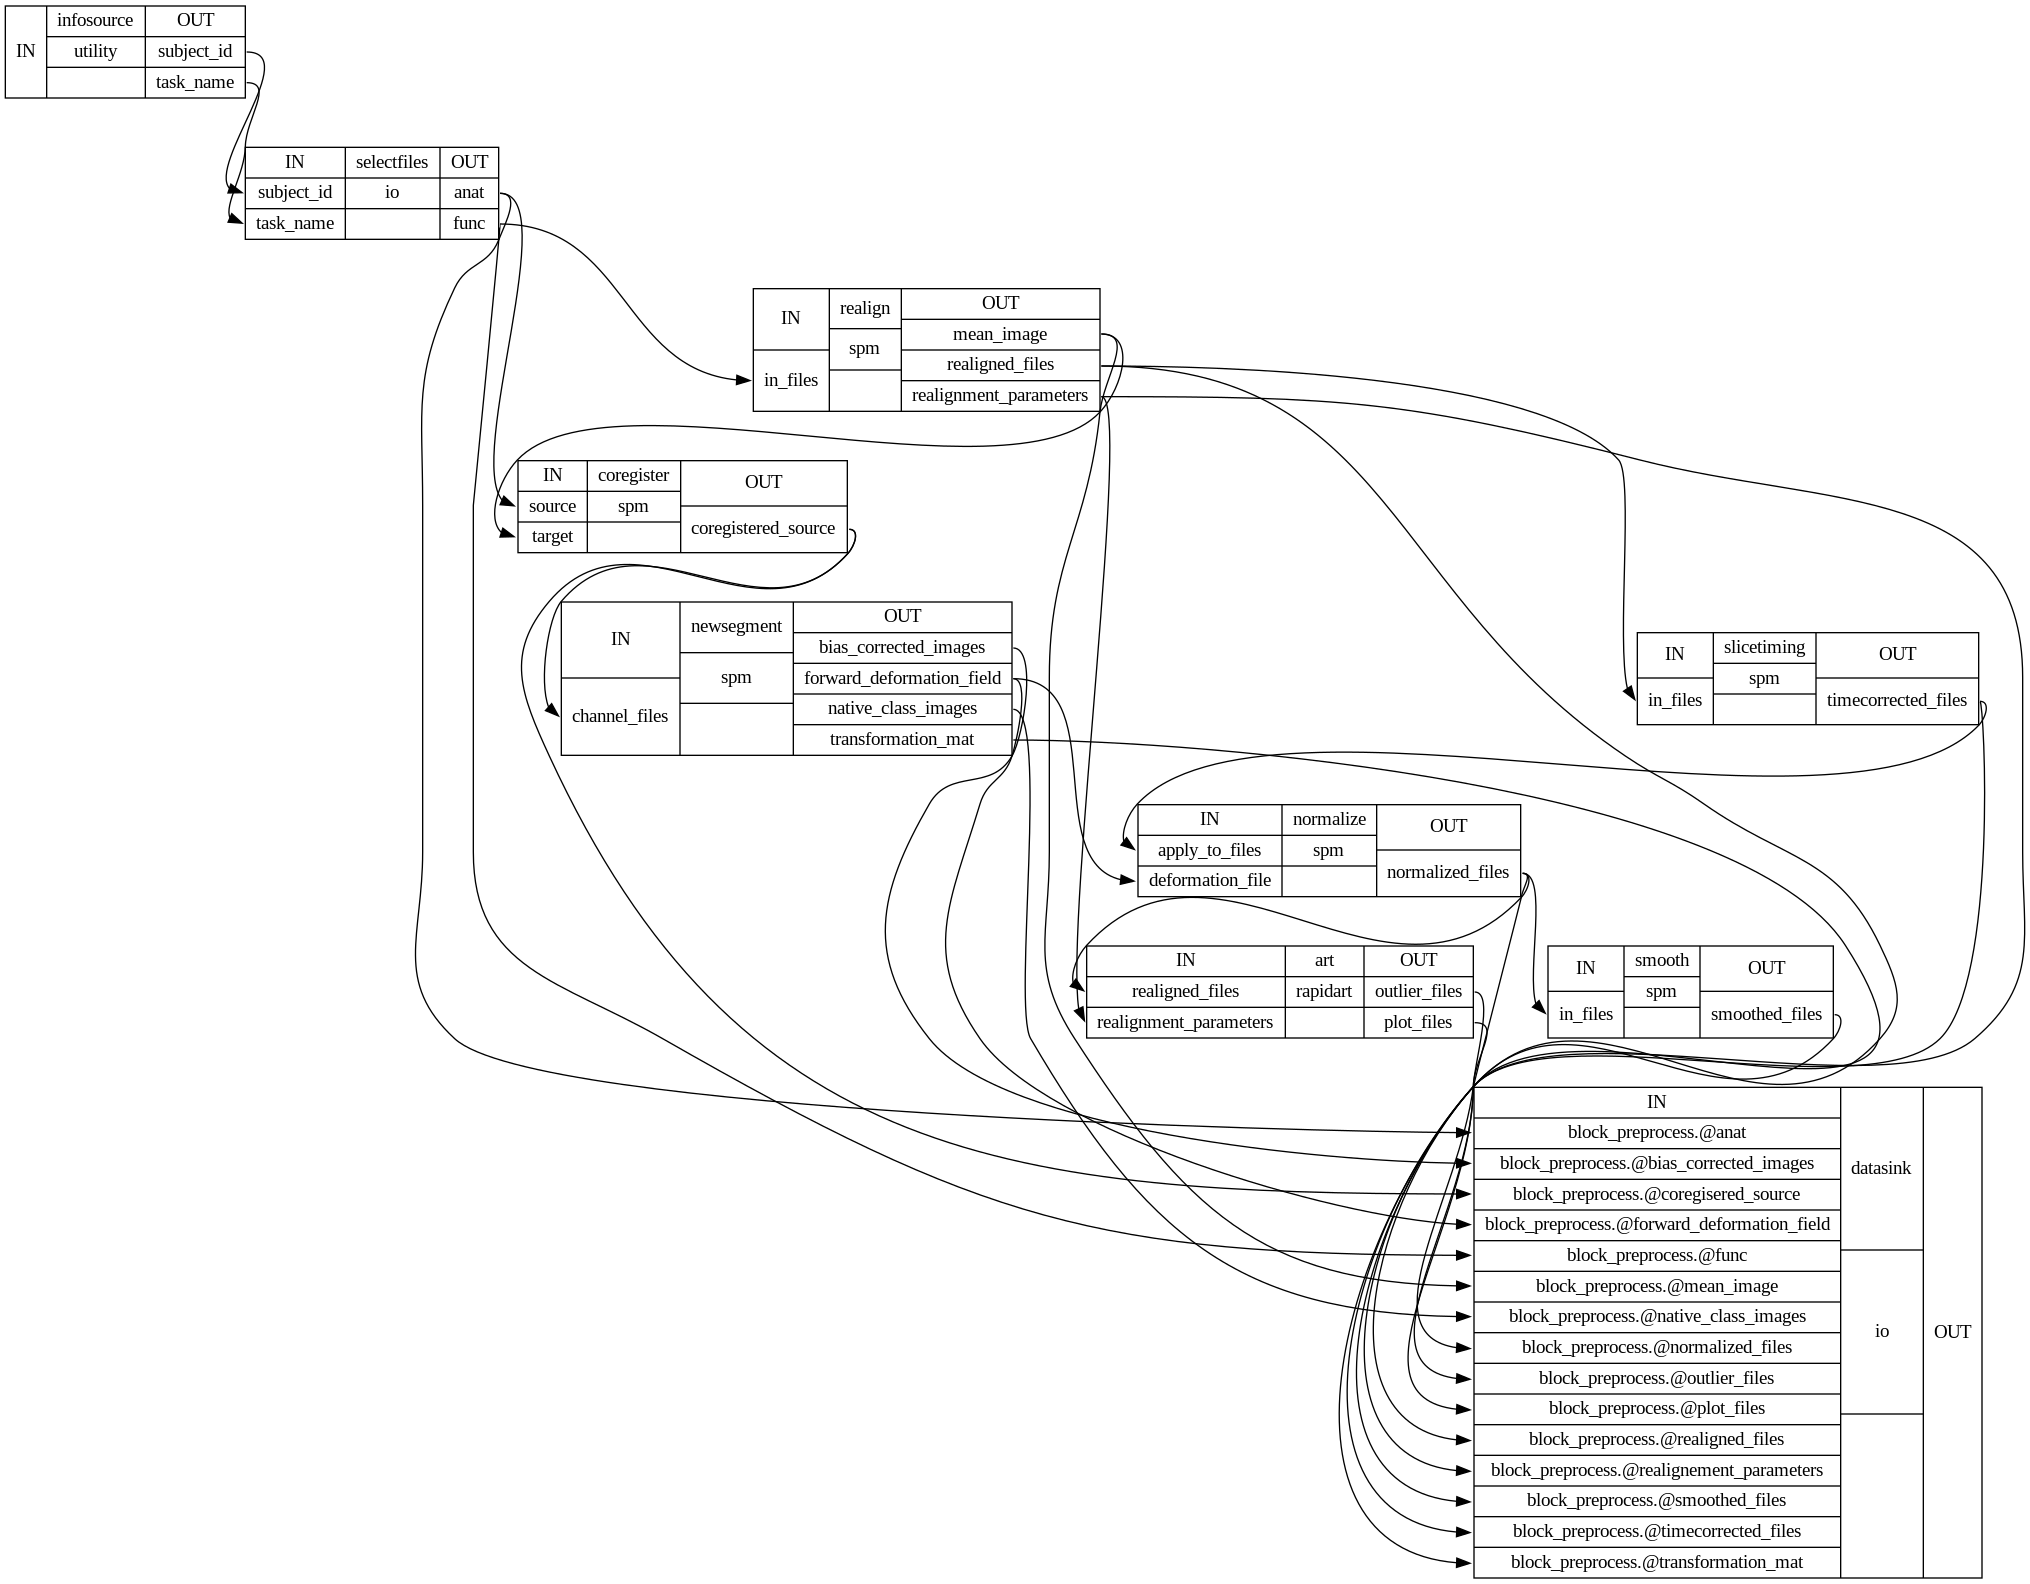

In [20]:
Image(filename=os.path.join(block_preprocess.base_dir, 'nipype_block_preprocess', 'flat_block_detailed.png'))

In [21]:
block_preprocess.run('MultiProc', plugin_args={'n_procs': 4})

240610-17:35:21,246 nipype.workflow INFO:
	 Workflow nipype_block_preprocess settings: ['check', 'execution', 'logging', 'monitoring']
240610-17:35:21,252 nipype.workflow INFO:
	 Running in parallel.
240610-17:35:21,253 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:35:21,313 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/selectfiles".
240610-17:35:21,317 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240610-17:35:21,319 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.00051s.
240610-17:35:23,258 nipype.workflow INFO:
	 [Job 0] Completed (nipype_block_preprocess.selectfiles).
240610-17:35:23,263 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free

stty: 'standard input': Inappropriate ioctl for device


240610-17:35:55,38 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 25.305039s.


stty: 'standard input': Inappropriate ioctl for device


240610-17:35:55,288 nipype.workflow INFO:
	 [Job 1] Completed (nipype_block_preprocess.realign).
240610-17:35:55,291 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:35:55,373 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.coregister" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/coregister".
240610-17:35:55,373 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/slicetiming".
240610-17:35:55,394 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>
240610-17:35:55,400 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>
240610-17:35:57,290 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


240610-17:36:14,918 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 13.186168s.


stty: 'standard input': Inappropriate ioctl for device


240610-17:36:15,307 nipype.workflow INFO:
	 [Job 2] Completed (nipype_block_preprocess.slicetiming).
240610-17:36:15,308 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * nipype_block_preprocess.coregister
240610-17:36:17,279 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 14.588967s.
240610-17:36:17,310 nipype.workflow INFO:
	 [Job 3] Completed (nipype_block_preprocess.coregister).
240610-17:36:17,314 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:36:17,386 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.newsegment" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/newsegment".
240610-17:36:17,392 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.

stty: 'standard input': Inappropriate ioctl for device


240610-17:36:19,312 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * nipype_block_preprocess.newsegment


stty: 'standard input': Inappropriate ioctl for device


240610-17:37:16,135 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 52.235802s.


stty: 'standard input': Inappropriate ioctl for device


240610-17:37:17,371 nipype.workflow INFO:
	 [Job 4] Completed (nipype_block_preprocess.newsegment).
240610-17:37:17,375 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:37:17,418 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.normalize" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/normalize".
240610-17:37:17,452 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>
240610-17:37:19,374 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * nipype_block_preprocess.normalize
240610-17:37:33,468 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 16.013422s.


stty: 'standard input': Inappropriate ioctl for device


240610-17:37:35,389 nipype.workflow INFO:
	 [Job 5] Completed (nipype_block_preprocess.normalize).
240610-17:37:35,393 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:37:35,451 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.smooth" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/smooth".
240610-17:37:35,451 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.art" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/art".
240610-17:37:35,455 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>
240610-17:37:35,455 nipype.workflow INFO:
	 [Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>
240610-17:37:36,862 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 1.4055309999999999s.
240610-17:37:37,3

stty: 'standard input': Inappropriate ioctl for device


240610-17:37:49,403 nipype.workflow INFO:
	 [Job 6] Completed (nipype_block_preprocess.smooth).
240610-17:37:49,407 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240610-17:37:49,464 nipype.workflow INFO:
	 [Node] Setting-up "nipype_block_preprocess.datasink" in "/home/matay/spmbasics/data/output/workingdir/nipype_block_preprocess/_subject_id_01_task_name_auditory/datasink".
240610-17:37:49,472 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240610-17:37:49,474 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.001004s.
240610-17:37:51,405 nipype.workflow INFO:
	 [Job 8] Completed (nipype_block_preprocess.datasink).
240610-17:37:51,409 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
